In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [50]:
def imshow(*args, **kwargs):
    plt.figure()
    plt.imshow(*args, **kwargs)
    plt.show()

In [81]:
CAMERA_MATRIX = np.array([[722.47843533, 0., 345.76148326], [0., 719.46836039, 215.29777186], [0., 0., 1.]])
DIST_COEFFS = np.array([[ 0.060491, -0.16982899, 0.00052914, 0.00505482, 0.31064351]])

MARKER_DICT = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
# MARKER_LENGTH = 0.34  # Physical marker length size
MARKER_LENGTH = 0.165  # Physical marker length size

In [73]:
import math

def gen_aruco_markers(size, columns, rows):
    
    fig = plt.figure(figsize=(8, 8))
    
    for i in range(1, columns*rows +1):
        marker = cv2.aruco.drawMarker(MARKER_DICT, i, size)    
        
        ax = fig.add_subplot(rows, columns, i)
        ax.axis('off')
        plt.imshow(marker, cmap='gray')
    
    plt.show()

def detect_markers(img):
    """Returns corners, ids, rejectedImgPoints."""
    return cv2.aruco.detectMarkers(img, MARKER_DICT)

def draw_markers(img, corners, ids=None):
    """Returns img with markers drawn."""
    return cv2.aruco.drawDetectedMarkers(img, corners, ids)

def estimate_marker_pose(corners):
    """returns rvecs, tvecs, _objPoints."""
    return cv2.aruco.estimatePoseSingleMarkers(corners, MARKER_LENGTH, CAMERA_MATRIX, DIST_COEFFS)

def draw_axis(img, rvec, tvec):
    """Draw the pose estimate on the img."""
    return cv2.aruco.drawAxis(img, CAMERA_MATRIX, DIST_COEFFS, rvec, tvec, MARKER_LENGTH)

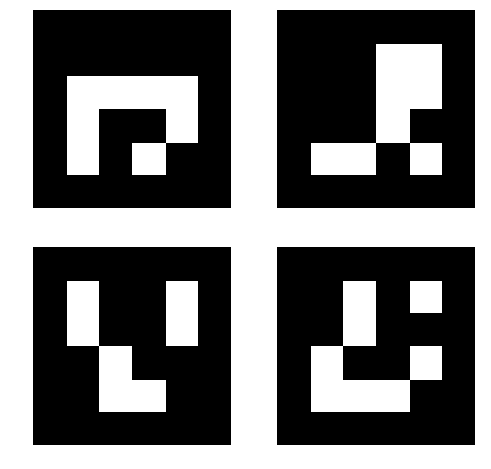

In [74]:
# Generate ARUCO markers
gen_aruco_markers(200, 2, 2)

In [131]:
# setup capture
camera = cv2.VideoCapture(0)

height = 480
width = 640
fps = 60

camera.set(cv2.CAP_PROP_FRAME_WIDTH, width)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
camera.set(cv2.CAP_PROP_FPS, fps)
# camera.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0.1)

# define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, fps, (width, height))
record = False

rvecs, tvecs = None, None

# capture loop
while True:
    # get frame
    ret, frame = camera.read()
    
    # detect aruco markers
    corners, ids, rejects = detect_markers(frame)
    
    # Draw the markers
    frame = draw_markers(frame, corners, ids)
    
    # Get pose estimates
    rvecs, tvecs, _ = estimate_marker_pose(corners)

    # Draw the poses
    if rvecs is not None:
        # Draw axes
        for r, t in zip(rvecs, tvecs):
            draw_axis(frame, r, t)
    
        marker = 0
        # Write rotation in each coord on frame
        text = "x: %.2f" % (rvecs[marker][0][0])
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, [0,0,255])
        
        text = "y: %.2f" % (rvecs[marker][0][1])
        cv2.putText(frame, text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, [0,255,0])

        text = "z: %.2f" % (rvecs[marker][0][2])
        cv2.putText(frame, text, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, [255,0,0])
    
        if rvecs[marker][0][0] < 0:
            # keypress occured
            cv2.putText(frame, "KEYPRESS", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, [255,255,255])
    
    # Show frames
    cv2.imshow('frame', frame)
    
    # write the flipped frame
    record and out.write(frame)

    # KEYBOARD INPUT ----------------------------------------------
    k = cv2.waitKey(1)
    
    if k & 0xFF == ord('q'):
        break
    elif k & 0xFF == ord('p'):
        cv2.imwrite('markers.png', frame)
        imshow(frame)
    elif k & 0xFF == ord('r'):
        record = not record
        

# clean up
camera.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)  # extra waitKey sometimes needed to close camera window

-1

## TODO 
- output key number if pressed
- make press detection more robust
    - pressed if last 2 of 3 frames shows pressed
- calculate velocity of a pressed key